In [1]:
import logging

import numpy as np
import probtorch
import torch

import bouncing_ball
import bouncing_ball_data
import combinators
import foldable
import importance
import mcmc
import utils

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
## dataset parameters
T = 75 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [5]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [6]:
num_particles = (100,)

In [7]:
init_bouncing_ball = combinators.PrimitiveCall(bouncing_ball.init_bouncing_ball)

In [8]:
bouncing_ball_step = combinators.PrimitiveCall(bouncing_ball.bouncing_ball_step)

In [9]:
def proposal_step():
    return combinators.PrimitiveCall(bouncing_ball.ProposalStep(), name='bouncing_ball_step')

In [10]:
prior_init_params = {
    'position_0': {
        'loc': torch.zeros(2),
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'loc': {
            'loc': torch.ones(2),
            'scale': torch.ones(2),
        },
        'cov': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [11]:
variational_init_params = {
    'position_0': {
        'loc': torch.zeros(2),
        'scale': torch.ones(2),
    },
    'alpha_0': {
        'concentration': torch.ones(4),
    },
    'alpha_1': {
        'concentration': torch.ones(4),
    },
    'alpha_2': {
        'concentration': torch.ones(4),
    },
    'alpha_3': {
        'concentration': torch.ones(4),
    },
    'alpha_4': {
        'concentration': torch.ones(4),
    },
    'directions': {
        'loc': {
            'loc': torch.ones(2),
            'scale': torch.ones(2),
        },
        'cov': {
            'loc': torch.eye(2).expand(4, 2, 2),
            'scale': torch.ones(4, 2, 2),
        },
    },
}

In [12]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['displacement_%d' % i] = displacements[i-1]
    
    return trajectory, displacements, data

In [13]:
def accumulate_trajectory(inference):
    result = torch.zeros(num_particles[0], len(trajectory), 2)
    result[:, 0] = inference['Reduce(Foldable(SideEffect(bouncing_ball_step, bouncing_ball_step)))/0/init_bouncing_ball/position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['Reduce(Foldable(SideEffect(bouncing_ball_step, bouncing_ball_step)))/%d/Foldable(SideEffect(bouncing_ball_step, bouncing_ball_step))(%d,)/bouncing_ball_step/displacement_%d' % (t, t, t+1)].value
    return result

In [14]:
def graph_position_trajectory(positions, T, s):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    plt.savefig('position_trajectory_%d.pdf' % s)

In [15]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [16]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [17]:
def generative_model(data, params):
    params['position_0']['loc'] = data['position_0']
    init_population = combinators.hyper_population(init_bouncing_ball, num_particles,
                                                   hyper=params)
    return mcmc.reduce_resample_move_smc(bouncing_ball_step, num_particles, lambda: range(T),
                                         initializer=init_population)

In [18]:
def proposal_model(data, params):
    params['position_0']['loc'] = data['position_0']
    init_proposal = combinators.hyper_population(init_bouncing_ball, num_particles,
                                                 trainable=params)
    return foldable.Reduce(foldable.Foldable(proposal_step(), initializer=init_proposal), lambda: range(T))

In [19]:
def posterior_model(data, params, step_proposal):
    generative_params = prior_init_params.copy()
    generative_params['position_0']['loc'] = data['position_0']
    
    generative_init = combinators.hyper_population(init_bouncing_ball, num_particles,
                                                   hyper=generative_params)
    params['position_0']['loc'] = data['position_0']
    proposal_init = combinators.hyper_population(init_bouncing_ball, num_particles, hyper=params)
    init_posterior = combinators.score_under_proposal(proposal_init, generative_init)
    
    step_posterior = combinators.score_under_proposal(step_proposal, bouncing_ball_step)
    
    return mcmc.reduce_resample_move_smc(step_posterior, num_particles, lambda: range(T), initializer=init_posterior)

01/30/2019 15:19:45 EUBO=-8.19149597e+02 at epoch 1
01/30/2019 15:19:45 EUBO=3.41660881e+01 at epoch 2
01/30/2019 15:19:46 EUBO=2.64942688e+02 at epoch 3
01/30/2019 15:19:47 EUBO=-7.21571436e+03 at epoch 4
01/30/2019 15:19:48 EUBO=1.01431320e+02 at epoch 5
01/30/2019 15:19:48 EUBO=6.61640091e+01 at epoch 6
01/30/2019 15:19:49 EUBO=-3.90529102e+03 at epoch 7
01/30/2019 15:19:50 EUBO=-2.78261841e+02 at epoch 8
01/30/2019 15:19:51 EUBO=-1.63584290e+02 at epoch 9
01/30/2019 15:19:52 EUBO=-9.66260910e+01 at epoch 10
01/30/2019 15:19:52 EUBO=-2.44989819e+03 at epoch 11
01/30/2019 15:19:53 EUBO=-2.60651474e+01 at epoch 12
01/30/2019 15:19:54 EUBO=-2.38498962e+02 at epoch 13
01/30/2019 15:19:55 EUBO=2.81712646e+01 at epoch 14
01/30/2019 15:19:55 EUBO=-1.54811523e+03 at epoch 15
01/30/2019 15:19:56 EUBO=-6.46387695e+02 at epoch 16
01/30/2019 15:19:57 EUBO=-5.18106613e+01 at epoch 17
01/30/2019 15:19:58 EUBO=-1.85093262e+02 at epoch 18
01/30/2019 15:19:59 EUBO=2.33766708e+01 at epoch 19
01/30/20

Epoch   464: reducing learning rate of group 0 to 5.0000e-02.


01/30/2019 15:25:41 EUBO=-3.65586426e+02 at epoch 466
01/30/2019 15:25:42 EUBO=-5.99157043e+02 at epoch 467
01/30/2019 15:25:43 EUBO=-1.08172339e+03 at epoch 468
01/30/2019 15:25:43 EUBO=5.38159847e+00 at epoch 469
01/30/2019 15:25:44 EUBO=-2.01681747e+01 at epoch 470
01/30/2019 15:25:45 EUBO=-2.59229028e+03 at epoch 471
01/30/2019 15:25:46 EUBO=-2.69951855e+03 at epoch 472
01/30/2019 15:25:46 EUBO=-1.67974365e+03 at epoch 473
01/30/2019 15:25:47 EUBO=-3.82804810e+02 at epoch 474
01/30/2019 15:25:48 EUBO=-5.38752670e+01 at epoch 475
01/30/2019 15:25:49 EUBO=-9.74352646e+01 at epoch 476
01/30/2019 15:25:49 EUBO=1.41554022e+01 at epoch 477
01/30/2019 15:25:50 EUBO=2.62644714e+02 at epoch 478
01/30/2019 15:25:51 EUBO=-4.06663971e+02 at epoch 479
01/30/2019 15:25:52 EUBO=-1.32400452e+03 at epoch 480
01/30/2019 15:25:52 EUBO=4.14264297e+01 at epoch 481
01/30/2019 15:25:53 EUBO=-1.17230768e+01 at epoch 482
01/30/2019 15:25:54 EUBO=-5.06146240e+02 at epoch 483
01/30/2019 15:25:55 EUBO=-4.3763

Epoch   665: reducing learning rate of group 0 to 2.5000e-02.


01/30/2019 15:28:12 EUBO=-1.08755469e+03 at epoch 667
01/30/2019 15:28:12 EUBO=1.69083900e+01 at epoch 668
01/30/2019 15:28:13 EUBO=-1.01256934e+04 at epoch 669
01/30/2019 15:28:14 EUBO=-2.80682678e+02 at epoch 670
01/30/2019 15:28:14 EUBO=-2.07718689e+02 at epoch 671
01/30/2019 15:28:15 EUBO=3.62617569e+01 at epoch 672
01/30/2019 15:28:16 EUBO=-1.60869995e+03 at epoch 673
01/30/2019 15:28:17 EUBO=-1.86024670e+03 at epoch 674
01/30/2019 15:28:17 EUBO=-8.45215378e+01 at epoch 675
01/30/2019 15:28:18 EUBO=-1.14875727e+01 at epoch 676
01/30/2019 15:28:19 EUBO=-2.04134277e+03 at epoch 677
01/30/2019 15:28:20 EUBO=4.01552200e+01 at epoch 678
01/30/2019 15:28:20 EUBO=-3.89450500e+02 at epoch 679
01/30/2019 15:28:21 EUBO=4.07013626e+01 at epoch 680
01/30/2019 15:28:22 EUBO=-1.05021416e+02 at epoch 681
01/30/2019 15:28:23 EUBO=-6.14762354e+03 at epoch 682
01/30/2019 15:28:23 EUBO=1.04938393e+02 at epoch 683
01/30/2019 15:28:24 EUBO=-1.40124817e+02 at epoch 684
01/30/2019 15:28:25 EUBO=1.275919

Epoch   866: reducing learning rate of group 0 to 1.2500e-02.


01/30/2019 15:30:42 EUBO=5.44851685e+01 at epoch 868
01/30/2019 15:30:42 EUBO=4.19991837e+01 at epoch 869
01/30/2019 15:30:43 EUBO=-1.84337997e+01 at epoch 870
01/30/2019 15:30:44 EUBO=-4.96586853e+02 at epoch 871
01/30/2019 15:30:45 EUBO=1.27987053e+02 at epoch 872
01/30/2019 15:30:45 EUBO=6.12819061e+01 at epoch 873
01/30/2019 15:30:46 EUBO=1.09253578e+02 at epoch 874
01/30/2019 15:30:47 EUBO=1.47778137e+02 at epoch 875
01/30/2019 15:30:48 EUBO=7.47534866e+01 at epoch 876
01/30/2019 15:30:48 EUBO=-1.43828149e+03 at epoch 877
01/30/2019 15:30:49 EUBO=-7.98705017e+02 at epoch 878
01/30/2019 15:30:50 EUBO=1.38654572e+02 at epoch 879
01/30/2019 15:30:51 EUBO=-1.96708630e+03 at epoch 880
01/30/2019 15:30:51 EUBO=-2.14438843e+02 at epoch 881
01/30/2019 15:30:52 EUBO=1.10080513e+02 at epoch 882
01/30/2019 15:30:53 EUBO=4.49725418e+01 at epoch 883
01/30/2019 15:30:53 EUBO=1.43924591e+02 at epoch 884
01/30/2019 15:30:54 EUBO=-1.64509201e+01 at epoch 885
01/30/2019 15:30:55 EUBO=-2.72915161e+0

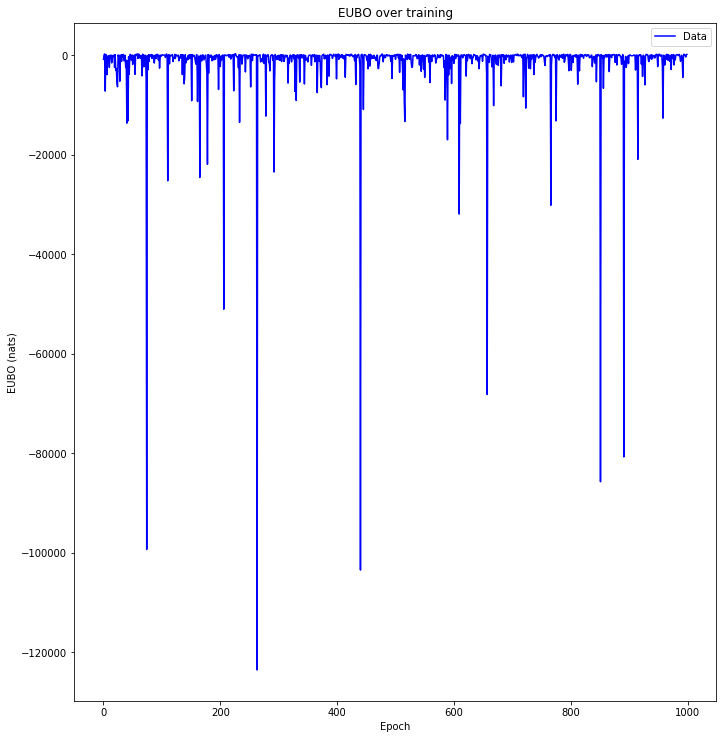

In [20]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    bouncing_ball_smc = generative_model(data, prior_init_params.copy())
    bouncing_ball_proposal = proposal_model(data, variational_init_params.copy())
    importance_sampler = combinators.score_under_proposal(bouncing_ball_smc, bouncing_ball_proposal)
    
    inference, trained_params, eubos = importance.variational_importance(
        importance_sampler, 1000, data,
        use_cuda=False, lr=1e-1, inclusive_kl=True,
        patience=200,
    )
    trained_params = utils.vardict({
        k.rsplit('.')[-1]: v for k, v in trained_params.items()
        if 'second' in k
    })
    utils.plot_evidence_bounds(eubos, False)
    
    bouncing_ball_posterior = posterior_model(data, trained_params, bouncing_ball_proposal.folder.operator)
    _, inference, (positions, _, A_pred, final_mu, final_cov) = bouncing_ball_posterior.simulate(data=data)
    As_pred[s] = A_pred.mean(dim=0).detach().numpy()
    final_mus[s] = final_mu.mean(dim=0).detach().numpy()
    final_covs[s] = final_cov.mean(dim=0).detach().numpy()
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory[:, 1:, :].mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce(Foldable(SideEffect(bouncing_ball_step, bouncing_ball_step)))/%d/Foldable(SideEffect(bouncing_ball_step, bouncing_ball_step))(%d,)/bouncing_ball_step/displacement_%d' % (t, t, t+1)].value for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_position_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    modal_directions[s] = bouncing_ball.reflect_directions(trained_params['directions']['loc']['loc'].unsqueeze(0)).squeeze(0)
    
    plt.close('all')

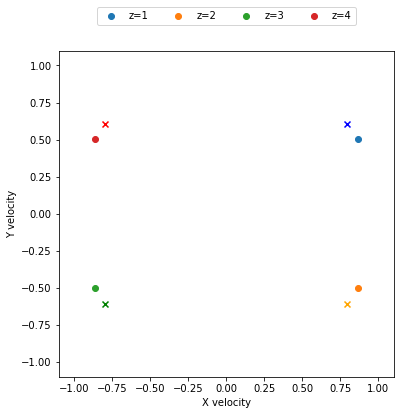

In [21]:
graph_velocity_frequencies(modal_directions.detach())

In [22]:
import bouncing_ball_plots

In [23]:
fs = 3 ## figure size
vmax = 0.3 ## cmap maximum value, to make off-diagonal elements more visible
width_space = 0.05 # space between figures
height_space = 0.05 # space between figures
cov_flag = False # plot the covariances or not
legend_flag = False # plot the legend bar or not
save_flag = True ## save or not

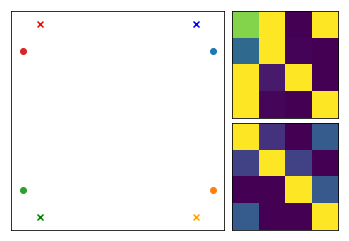

In [24]:
## plot method 1
bouncing_ball_plots.plot_circle_transition(init_v, final_mus, final_covs,
                                           As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

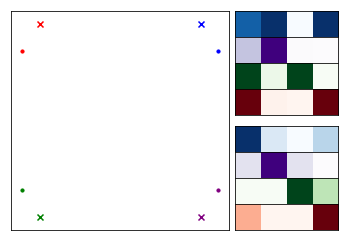

In [25]:
## plot method 2
bouncing_ball_plots.plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)

In [26]:
def plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag):

    As_infer = As_pred / As_pred.sum(-1)[:, :, None]
    As_infer = As_infer.mean(0)
    As_true_ave = As_true.mean(0)

    fig = plt.figure(figsize=(fs*1.5 + width_space,fs + height_space))
    gs1 = gridspec.GridSpec(1, 1)
    # , width_ratios=[2,1], height_ratios=[1,1]
    gs1.update(left=0.0, bottom=0.0, right=(2/3), top=1.0, wspace=width_space, hspace=height_space)
    ax1 = fig.add_subplot(gs1[0])

    # ax3 = fig.add_subplot(gs[1, 1])
    ax1.set_xticks([])
    ax1.set_yticks([])

    gs2 = gridspec.GridSpec(4, 1)
    gs2.update(left=2/3 + (1/3)*width_space, bottom=0.5+(1/2)*width_space, right=1.0, top=1.0, wspace=0, hspace=0)
    ax2 = fig.add_subplot(gs2[0, 0])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax3 = fig.add_subplot(gs2[1, 0])
    ax3.set_xticks([])
    ax3.set_yticks([])
    ax4 = fig.add_subplot(gs2[2, 0])
    ax4.set_xticks([])
    ax4.set_yticks([])
    ax5 = fig.add_subplot(gs2[3, 0])
    ax5.set_xticks([])
    ax5.set_yticks([])

    gs3 = gridspec.GridSpec(4, 1)
    gs3.update(left=2/3 + (1/3)*width_space, bottom=0.0, right=1.0, top=0.5 - (1/2)*width_space, wspace=0, hspace=0)
    ax6 = fig.add_subplot(gs3[0, 0])
    ax6.set_xticks([])
    ax6.set_yticks([])
    ax7 = fig.add_subplot(gs3[1, 0])
    ax7.set_xticks([])
    ax7.set_yticks([])
    ax8 = fig.add_subplot(gs3[2, 0])
    ax8.set_xticks([])
    ax8.set_yticks([])
    ax9 = fig.add_subplot(gs3[3, 0])
    ax9.set_xticks([])
    ax9.set_yticks([])
    markersize = 10.0
    colors = ['b', 'Purple', 'g', 'r']
    ## plot left one
    ax1.scatter(init_v[:,0], init_v[:,1], s=markersize, color=colors[0], label='z=1')
    ax1.scatter(init_v[:,0], -init_v[:,1], s=markersize, color=colors[1], label='z=2')
    ax1.scatter(-init_v[:,0], -init_v[:,1], s=markersize, color=colors[2], label='z=3')
    ax1.scatter(-init_v[:,0], init_v[:,1], s=markersize, color=colors[3], label='z=4')

    for k in range(K):
        ax1.scatter(final_mus[:,k,0], final_mus[:,k,1], c=colors[k], marker='x')
    if cov_flag:
        for k in range(K):
            for s in range(num_series):
                plot_cov_ellipse(cov=final_covs[s, k, :, :], pos=final_mus[s, k, :], nstd=0.3, ax=ax1, alpha=0.3)
    #    ax1.set_xlabel('x velocity')
    #    ax1.set_ylabel('y velocity')
    if legend_flag:
        ax1.legend(loc='upper center', bbox_to_anchor=(0.75, 1.15), ncol=4)

    ax2.imshow(As_infer[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax3.imshow(As_infer[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax4.imshow(As_infer[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax5.imshow(As_infer[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    ax6.imshow(As_true_ave[None, 0,:], cmap='Blues', vmin=0, vmax=vmax)
    ax7.imshow(As_true_ave[None, 1,:], cmap='Purples', vmin=0, vmax=vmax)
    ax8.imshow(As_true_ave[None, 2,:], cmap='Greens', vmin=0, vmax=vmax)
    ax9.imshow(As_true_ave[None, 3,:], cmap='Reds', vmin=0, vmax=vmax)

    if save_flag:
        fig.savefig('combinator_results.pdf', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.svg', dpi=600, bbox_inches='tight')
        fig.savefig('combinator_results.png', dpi=600, bbox_inches='tight')

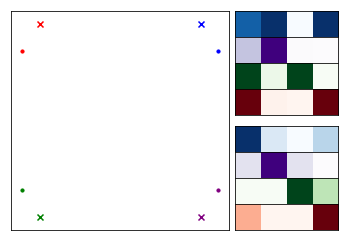

In [27]:
## plot method 2
plot_circle_transition_colorcode(init_v, final_mus, final_covs, As_pred, As_true, K, fs, vmax, width_space, height_space, cov_flag, legend_flag, save_flag)